# Co-ordinate transformation

Σκοπός είναι, έχοντας μία τυχαία μορφή σημείων (π.χ ευθεία), και ένα σημείο, να τα μεταφέρουμε στην αρχή των αξόνων διατηρώντας τα χαρακτηριστικά τους. Η ευθεία θα είναι η τροχιά του ρομπότ, ενώ το σημείο θα είναι το RFID tag.

***

## Rotation για τα data από το simulation

Έστω ότι έχουμε την ευθεία $ y = 2x + 5 $ για $x$ από $0$ μέχρι $10$, και το σημείο $(4,20)$, όπως φαίνεται παρακάτω.

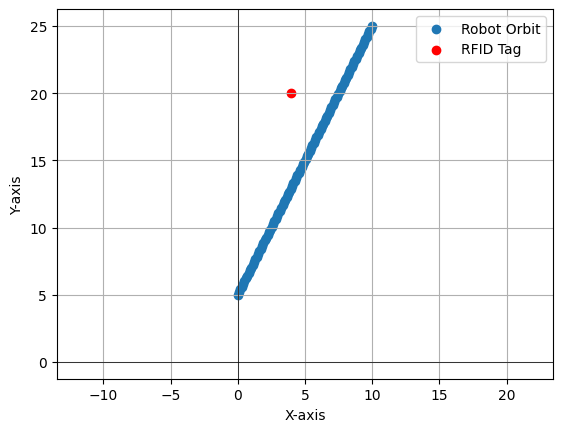

In [1]:
import matplotlib.pyplot as plt
import numpy as np

# Hypothetical Robot Orbit
x = np.linspace(0, 10, 100)
y = 2*x + 5

# Robot Orbit
plt.scatter(x, y , label = 'Robot Orbit')

# RFID Tag
rfid_pos = [4, 20]
plt.scatter(rfid_pos[0],rfid_pos[1], label = 'RFID Tag', color = 'red')

# Labels and legend
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.axhline(0, color='black', linewidth=0.5)  
plt.axvline(0, color='black', linewidth=0.5)
plt.legend()
plt.axis('equal')
plt.grid(True)

# Show plot
plt.show()

Για να μετατρέψουμε μία τυχαία ευθεία στον Χ άξονα, αρχικά αφαιρούμε από όλα τα σημεία το αρχικό $(x_0, y_0)$, στην συνέχεια εντοπίζουμε την κλίση της ευθείας (ή οποιαδήποτε άλλής μορφής καμπύλη) από το αρχικό $(x_0, y_0)$ και το τελικό $(x_n, y_n)$ και στρέφουμε όλα τα σημεία σύμφωνα με τον παρακάτω πίνακα στροφής.

$$
R = \begin{bmatrix} 
\cos\theta & \sin\theta \\ 
-\sin\theta & \cos\theta 
\end{bmatrix}
$$



Χρησιμοποιούμε την ```arctan2``` για να μην χρειάζεται να μελετάμε υποπεριπτώσεις.

**Επιπλέον** σε περίπτωση που η τελική θέση του RFID Tag είναι στον αρνητικό ημιάξονα $y$ αλλάζουμε τα πρόσημα όλων των $y$, με σκοπό να τοποθετηθέι το Tag σε θετικές τιμές.

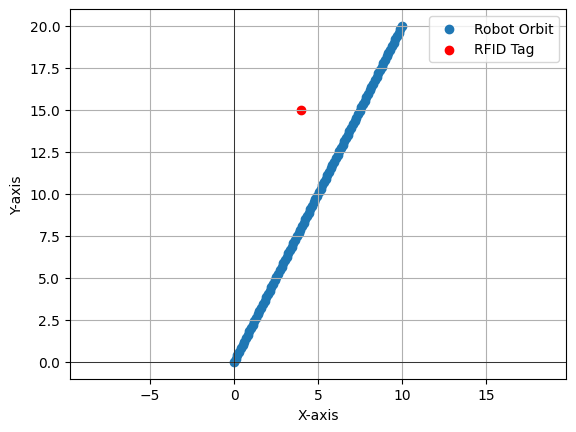

In [2]:
#Subtract the starting point from all the points
y_new = y - y[0]
x_new = x - x[0]

rfid_new = [rfid_pos[0] - x[0], rfid_pos[1] - y[0]]

# Plot the new orbit and RFID Tag
plt.scatter(x_new, y_new , label = 'Robot Orbit')

# RFID Tag
plt.scatter(rfid_new[0],rfid_new[1], label = 'RFID Tag', color = 'red')

# Labels and legend
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.axhline(0, color='black', linewidth=0.5)  
plt.axvline(0, color='black', linewidth=0.5)
plt.legend()
plt.axis('equal')
plt.grid(True)

# Show plot
plt.show()

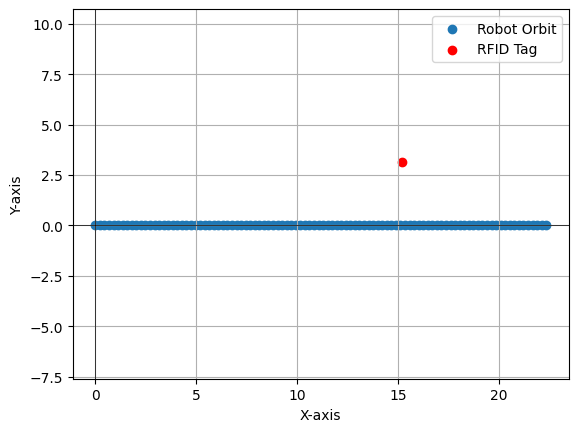

In [3]:
# Calculate the angle
angle = np.arctan2(y_new[-1] , x_new[-1])

# Rotate all the points
x_rot = x_new * np.cos(angle) + y_new * np.sin(angle)
y_rot = -x_new * np.sin(angle) + y_new * np.cos(angle)

# Rotate the RFID Tag
rfid_rot = [rfid_new[0] * np.cos(angle) + rfid_new[1] * np.sin(angle), -rfid_new[0] * np.sin(angle) + rfid_new[1] * np.cos(angle)]

# Check if the RFID Tag is in the negative y-axis, then move everything to the positive y-axis
if rfid_rot[1] < 0:
    y_rot = -y_rot
    rfid_rot[1] = -rfid_rot[1]

# Plot the new orbit and RFID Tag
plt.scatter(x_rot, y_rot , label = 'Robot Orbit')

# RFID Tag
plt.scatter(rfid_rot[0],rfid_rot[1], label = 'RFID Tag', color = 'red')

# Labels and legend
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.axhline(0, color='black', linewidth=0.5)  
plt.axvline(0, color='black', linewidth=0.5)
plt.legend()
plt.axis('equal')
plt.grid(True)

# Show plot
plt.show()


Μετατρέπουμε την παραπάνω διαδικασία σε μία συνάρτηση η οποία προορίζεται να χρησιμοποιηθεί στα training data από το simulation.

In [4]:
def rotate_points(x, y, rfid_pos):
    # Subtract the starting point from all the points
    y_new = y - y[0]
    x_new = x - x[0]

    rfid_new = np.array([rfid_pos[0] - x[0], rfid_pos[1] - y[0]])

    # Calculate the angle
    angle = np.arctan2(y_new[-1], x_new[-1])

    # Create the rotation matrix
    rotation_matrix = np.array([[np.cos(angle), np.sin(angle)],
                                [-np.sin(angle), np.cos(angle)]])

    # Rotate all the points
    rotated_points = np.dot(rotation_matrix, np.vstack((x_new, y_new)))
    x_rot, y_rot = rotated_points[0], rotated_points[1]

    # Replace very small values with 0
    x_rot = np.where(np.abs(x_rot) < 1e-10, 0, x_rot)
    y_rot = np.where(np.abs(y_rot) < 1e-10, 0, y_rot)

    # Rotate the RFID Tag
    rfid_rot = np.dot(rotation_matrix, rfid_new)

    # Check if the RFID Tag is in the negative y-axis, then move everything to the positive y-axis and set the sign to -1
    sign = 1
    if rfid_rot[1] < 0:
        y_rot = -y_rot
        rfid_rot[1] = -rfid_rot[1]
        sign = -1

    return x_rot, y_rot, rfid_rot, sign, angle

*******

## Συναρτήσεις για το real world problem

Στο πραγματικό πρόβλημα θα δεχόμαστε μία τυχαίας μορφή καμπύλη από το ρομπότ και θα πρέπει να την μεταφέρουμε στο $(0,0)$ κρατώντας την γωνία περιστροφής.

Για τα training_data δεν χρειάζεται αυτή η διαδικασία καθώς στο αρχείο ```Transformed_Coordinates.xlsx``` θα υπάρχουν τόσο οι παλιές όσο και οι καινούριες συντεταγμένες του RFID tag.

In [5]:
def rotate_curve(x, y):
    # Subtract the starting point from all the points
    y_new = y - y[0]
    x_new = x - x[0]

    # Calculate the angle
    angle = np.arctan2(y_new[-1], x_new[-1])

    # Create the rotation matrix
    rotation_matrix = np.array([[np.cos(angle), np.sin(angle)],
                                [-np.sin(angle), np.cos(angle)]])

    # Rotate all the points
    rotated_points = np.dot(rotation_matrix, np.vstack((x_new, y_new)))
    x_rot, y_rot = rotated_points[0], rotated_points[1]

    # Replace very small values with 0
    x_rot = np.where(np.abs(x_rot) < 1e-10, 0, x_rot)
    y_rot = np.where(np.abs(y_rot) < 1e-10, 0, y_rot)

    return x_rot, y_rot, angle

In [6]:
def return_point(x, y, rfid_pos, sign, angle):
    # If the rfid used to be on the negative y-plane we need to first return it there
    # If rfid was left from the robot sign = 1, else if it was right sign = -1
    rfid_pos[1] *= sign

    # Create the inverse rotation matrix
    inverse_rotation_matrix = np.array([[np.cos(-angle), np.sin(-angle)],
                                        [-np.sin(-angle), np.cos(-angle)]])

    # Rotate the rfid tag
    rfid_rot = np.dot(inverse_rotation_matrix, rfid_pos)

    # Add the starting coordinates
    rfid_rot += np.array((x[0], y[0]))

    return rfid_rot

### Διαγράμματα για κατανόηση

Έστω πάλι ότι η αρχική ευθεία είναι η $y = -5x + 3$ και το αρχικό σημείο το $(20,0)$

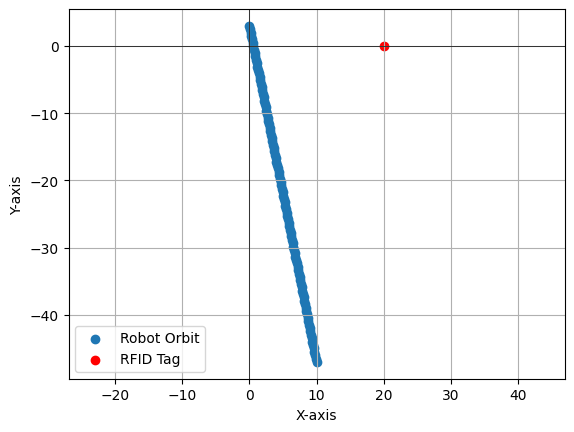

In [7]:
# Hypothetical Robot Orbit
x = np.linspace(0, 10, 100)
y = -5*x + 3

# Robot Orbit
plt.scatter(x, y , label = 'Robot Orbit')

# RFID Tag
rfid_pos = [20, 0]
plt.scatter(rfid_pos[0],rfid_pos[1], label = 'RFID Tag', color = 'red')

# Labels and legend
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.axhline(0, color='black', linewidth=0.5)  
plt.axvline(0, color='black', linewidth=0.5)
plt.legend()
plt.axis('equal')
plt.grid(True)

# Show plot
plt.show()

Περιστρέφουμε το σύστημα όπως και προηγουμένως 

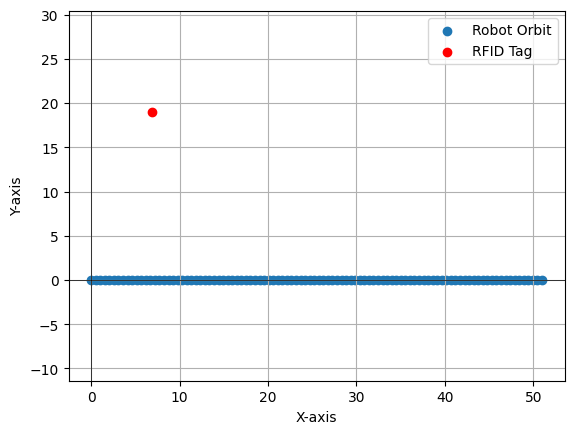

In [8]:
x_r, y_r, rfid_r, sign, angle = rotate_points(x,y,rfid_pos=rfid_pos)

# Plot the new orbit and RFID Tag
plt.scatter(x_r, y_r , label = 'Robot Orbit')

# RFID Tag
plt.scatter(rfid_r[0],rfid_r[1], label = 'RFID Tag', color = 'red')

# Labels and legend
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.axhline(0, color='black', linewidth=0.5)  
plt.axvline(0, color='black', linewidth=0.5)
plt.legend()
plt.axis('equal')
plt.grid(True)

# Show plot
plt.show()

Και τώρα θέλουμε να επιστρέψουμε τις συντεταγμένες του tag στο αρχικό σημείο.

In [9]:
return_point(x,y,rfid_r, sign, angle)

array([ 2.0000000e+01, -4.4408921e-16])

***